# numpy save, simulation results
in this we will save simulation results needed for graphs.

In [1]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [2]:
num_experiments = 100

In [73]:
#Import Statements & Define Constants
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
from scipy.stats import ks_2samp
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd
from tqdm import tqdm
from matplotlib.ticker import EngFormatter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import statistics


import dispersion as disp

%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass

[04:44:17] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


# Load NASA Exoplanet Archive data needed
Use archive to find planets that have compact inner period ratios

In [4]:
# load data of planets that have inner period ratio 1.1-1.5
df = pd.read_csv("compact_planet_data.csv", index_col=0)
df.head()

,Planet Name,Host Name,Orbital Period,Discovery Method,Semi-Major Axis (AU),Eccentricity,Radius (R_earth),Mass or Mass * sin(i) (M_earth),Stellar Mass (M_sun)
119,DMPP-1 b,DMPP-1,18.570,Radial Velocity,0.1462,0.083,5.29,24.27,1.21
120,DMPP-1 c,DMPP-1,6.584,Radial Velocity,0.0733,0.057,3.06,9.60,1.21
122,DMPP-1 e,DMPP-1,5.516,Radial Velocity,0.0651,0.070,1.86,4.13,1.21
194,GJ 180 b,GJ 180,17.133,Radial Velocity,0.0920,0.070,2.43,6.49,0.43
195,GJ 180 c,GJ 180,24.329,Radial Velocity,0.1290,0.090,2.41,6.40,0.43


# load from prelim .npy

In [5]:
pratios_observed = np.load('pratios_observed.npy')

In [6]:
observed_period_cdf = np.load('observed_period_cdf.npy')

In [80]:
kde_changing = np.load('kde_changing.npy')

In [82]:
e_list_orig = np.load('e_list.npy')
m_list = np.load('m_list.npy')

# waldo copy above here

# Dispersion for observed systems
D = 0.302449556680029

error = 0.0180067880312394 (SEM)

In [9]:
D = 0.302449556680029
D_error = 0.0180067880312394

# notes
kde_changing should be an array of multipliers for e_list and m_list, length 11

trials_pvalue should be an array of length num_experiments (=100) holding a pvalue for when the 71 systems are compared to observesd

# How to replicate data with SPOCK
We want to replicate the period ratio data using SPOCK. In order to do this, we start off by setting a range of eccentricities, masses, and period ratios to choose from. Based on KDE from observational data, there is different probabilities of obtaining certain parameters.

We generate simulations and determine their probability of surviving. We want to replicate the same number of systems observed with compact period ratios (99), so we generate 50 systems (2 period ratios each). We choose to use a system by generating a random number from 0 to 1, and if that number is less than the probability of the simulated system surviving, we use that system. Ex: If a simulated system has a 80% chance of surviving, there is an 80% chance that the random number will be under it, and we use it for a system that exists in our simulated world. 

In [33]:
#waldo code
def simulate_trios(D, error):
    """generates periods based on dispersion"""
    p1period = 1
    p2period = np.random.uniform(1.1,1.5) # thus pratio 1.1-1.5
    p3period = 0
    
    # calculate last period
    while p3period < p2period:
        s12= math.log10(p2period/p1period) #log of pratio1
        s23 = np.random.normal(s12, s12*D*3) # dispersion is a ratio, we dont know if pos or neg
        p3period = p2period*10**s23 # calculate period 3
    pratio2 = p3period/p2period
    return [p1period,p2period,p3period]

trioslist=[simulate_trios(.302449556680029, 0.226708237758116) for i in range(0,10000)]
# make histogram with inner pratio 1.3, 
# plt.hist(trioslist, bins = 100, density = True)
dispersion(trios=np.asarray(trioslist))

(0.3489066523591283, 0.001748557020778436)

In [61]:
def simulate_trios(D, error):
    period_1 = 1
    period_2 = np.random.uniform(1.1, 1.5)
    pratio1 = period_2/period_1
    s12 = np.log10(pratio1)
    period_3 = 0
    
    while period_3<period_2:
        s23 = np.random.normal(loc=s12, scale=s12*D*3)
        period_3 = period_2 * 10 ** s23
    pratio2 = period_3/period_2
    
    return [period_1, period_2, period_3]
trioslist=[simulate_trios(.302449556680029, 0.226708237758116) for i in range(0,10000)]
dispersion(trios=np.asarray(trioslist))

(0.3479801814330908, 0.0017178041929504643)

In [84]:
# saving pvalues for each trial
trials_pvalue_mean = []
trials_pvalue_stdev = [] 
final_dispersion = []

In [ ]:
from tqdm import tqdm 

# this saves lists of lists so we can save each from each ecc change
ecc_cumsum = []
ecc_final_pratios = [] 
ecc_pvalue = []
ecc_final_stability = []
ecc_final_simulations = []
ecc_final_all_pratios = []
ecc_final_bad_pratios = []
ecc_final_periods = []
ecc_inner_pratios = []
ecc_outer_pratios = []




# multiple trials to take an average CHANGE
num_experiments = 100
# 1/2 expected is D
# stdev_changing = [6*D, 7*D, 8*D, 9*D]

stdev = D*3 # should have disp .3


for a in range(len(kde_changing)):
    print('ECCENTRICITY ' + str(a+1)+'/11')
    
    #This initializes the lists that populations can be added into
    trials_cumsum = []
    trials_final_pratios = [] 
    trials_pvalue = []
    trials_final_stability = []
    trials_final_simulations = []
    trials_final_bad_pratios = []
    trials_final_all_pratios = []
    trials_final_periods = []
    trials_inner_pratios = []
    trials_outer_pratios = []
    #dispersion_list = []
    final_periods = []
#     stdev = stdev_changing[a]
    e_list = e_list_orig*kde_changing[a]
    for q in tqdm(range(num_experiments)):
#         if q % 20 == 0:
#             print(str(q+1)+'/'+str(num_experiments)) # print how many exp run every 20 exp
        spock_e_list = [] # final eccentricities of planets
        spock_p_list = [] # final period ratios of planets
        all_pratios = []
        bad_p_list = []
        spock_m_list = [] # final masses of planets
        final_stability = [] # final probabilities of each simulated system being stable
        final_simulations = [] # final simulations used
        inner_pratios = []
        outer_pratios = []
        
        #CHANGE
        while len(spock_p_list) < 71: # run until we get to 71 "simulated observations" 1.1-1.5
            #Get eccentricity and mass randomly
            #We're are testing a single system of 3 planets
            i = int(np.random.uniform(0,10000))
            temp_e1 = e_list[3*i] # choose random eccentricity, is there a reason why this is how it's randomly chosen
            temp_e2 = e_list[3*i+1]
            temp_e3 = e_list[3*i+2]
            temp_m1 = m_list[3*i] 
            temp_m2 = m_list[3*i+1] 
            temp_m3 = m_list[3*i+2] 
            # Get periods based on pearson r requirement and period distribution. 
            #Initialize to base values
            base_period = 1  #PLay with this value based on observed periods, but might not matter
            #.44 pearson r?
           # dispersion #0.1161#0.1161 #This standard deviation sets the pearson r change by 50%
#             d_error = dispersion(trios=get_trios(Plist = plist))[1] # dispersion error
#             pratio1 = p_list[int(np.random.uniform(0,num_iter))] # choose a ratio between planet, choose from array of random period ratios between 1.1-1.5
#             pratio2_log = np.random.normal(pratio1,stdev*pratio1) #Use random.normal to imitate pearson r - tune stdev to desired pearson r
#             pratio2 = 10**pratio2_log
            period_1 = 1
            period_2 = np.random.uniform(1.1, 1.5)
            pratio1 = period_2/period_1
            s12 = np.log10(pratio1)
            period_3 = 0
            
            while period_3 < period_2:
                s23 = np.random.normal(loc=s12, scale=stdev*s12)
                period_3 = period_2 * 10 ** s23
                
            pratio2 = period_3/period_2
            #Set the periods based on period ratios and base period
    
    
#             period_1, period_2, period_3 = simulate_trios(d, d_error)
#             pratio1 = period_2/period_1
#             pratio2 = period_3/period_2
#             period_1 = base_period


#             period_2 = period_1 * pratio1
#             period_3 = period_2 * pratio2

            # Making the 3planet temporary simulation
            temp_sim = rebound.Simulation()
            temp_sim.add(m=1) #Can possibly change mass of star, but might not matter
            temp_sim.add(m=temp_m1*mass_ratio, P = period_1, e = temp_e1)
            temp_sim.add(m=temp_m2*mass_ratio, P = period_2, e = temp_e2)
            temp_sim.add(m=temp_m3*mass_ratio, P = period_3, e = temp_e3)



            # Test stability of the temporary simulation
            temp_stability = fmodel.predict_stable(temp_sim)# get its spock probability for both groups of planets inner/outer

            # sets simulation stability to 0 if orbits cross
            if disp.check_crossing(temp_sim):
                temp_stability = 0

            r = np.random.random() # this generates a random number from 0-1
            if r < temp_stability: # condition will trigger temp_stability% of the time
                final_simulations.append(temp_sim) # append simulation to our list of "simulated observations" that survived
                spock_p_list.append(pratio1)
                if (pratio2 > 1.1 and pratio2 < 1.5): #between constraints for small p ratio
                    spock_p_list.append(pratio2)
                else:
                    bad_p_list.append(pratio2)
                inner_pratios.append(pratio1)
                outer_pratios.append(pratio2)
                all_pratios.append(pratio1)
                all_pratios.append(pratio2)
                #NEED TO FIGURE OUT
                spock_e_list.append(temp_e1)
                spock_e_list.append(temp_e2)
                spock_e_list.append(temp_e3)
                spock_m_list.append(temp_m1)
                spock_m_list.append(temp_m2)
                spock_m_list.append(temp_m3)
                final_stability.append(temp_stability) # append stability probability to list of stabilities that survived
                final_periods.append([period_1,period_2,period_3]) #trios!

            else:
                pass # simulated observation was unsuccessful. Continue to making a new system and repeat

        # make cdf in spock_p_cumsum
        spock_p_values, spock_p_base = np.histogram(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number))
        spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values)) #cdf!!!

        # ks test
        ksprob = scipy.stats.kstest(np.array(spock_p_list), np.array(pratios_observed), args=(), alternative='two-sided', method='exact')       
        pvalue = ksprob[1]
        
        # dispersion
#         dispersion_list.append(dispersion(trios=final_periods)[0])
        
        # SAVE DATA FROM AFTER WHILE LOOP, from all 71 runs
        # pvalue is 1 element for the 71 pratios created. this should be a list of length of num_experiments
        trials_pvalue.append(pvalue)
        
        trials_final_stability.append(final_stability) # list of stability arrays for each trial
        trials_final_pratios.append(spock_p_list) # list of period ratios for each trial
        trials_final_all_pratios.append(all_pratios)
        trials_final_bad_pratios.append(bad_p_list)
        trials_inner_pratios.append(inner_pratios)
        trials_outer_pratios.append(outer_pratios)
        trials_cumsum.append(spock_p_cumsum) # list of all cdfs corresponding to the period ratios 
        trials_final_simulations.append(final_simulations)
        trials_final_periods.append(final_periods)
    
    
    # list of list, from each change in eccentricity value
    final_dispersion.append(disp.dispersion(trios=final_periods))#statistics.mean(dispersion_list))
    
    # WHAT WE CARE ABOUT FOR SENSITIVITY TEST
    # ecc_pvalue is a LOL of ALL pvalues for each kde_changing
    # list is len(kde_changing) of list is len(num_experiments)
    ecc_pvalue.append(trials_pvalue) 
    
    ecc_final_stability.append(trials_final_stability) # list of stability arrays for each trial
    ecc_final_pratios.append(trials_final_pratios) # list of period ratios for each trial
    ecc_final_all_pratios.append(trials_final_all_pratios)
    ecc_final_bad_pratios.append(trials_final_bad_pratios)
    ecc_cumsum.append(trials_cumsum) # list of all cdfs corresponding to the period ratios 
    ecc_final_simulations.append(trials_final_simulations)
    ecc_final_periods.append(trials_final_periods)
    ecc_inner_pratios.append(trials_inner_pratios)
    ecc_outer_pratios.append(trials_outer_pratios)
    
    # easy access to mean and stdev, list 1 x len(kde_changing)
    trials_pvalue_mean.append(np.asarray(trials_pvalue).mean())
    trials_pvalue_stdev.append(statistics.stdev(trials_pvalue))

ECCENTRICITY 1/11


100%|███████████████████████████████████████| 100/100 [1:21:46<00:00, 49.07s/it]


ECCENTRICITY 2/11


100%|███████████████████████████████████████| 100/100 [1:31:11<00:00, 54.72s/it]


ECCENTRICITY 3/11


100%|███████████████████████████████████████| 100/100 [1:36:21<00:00, 57.81s/it]


ECCENTRICITY 4/11


100%|███████████████████████████████████████| 100/100 [1:45:54<00:00, 63.54s/it]


ECCENTRICITY 5/11


100%|███████████████████████████████████████| 100/100 [1:55:18<00:00, 69.18s/it]


ECCENTRICITY 6/11


100%|███████████████████████████████████████| 100/100 [2:07:32<00:00, 76.53s/it]


ECCENTRICITY 7/11


 66%|██████████████████████████▍             | 66/100 [1:31:01<43:22, 76.54s/it]

In [86]:
trials_pvalue_mean

[0.647368560779713, 0.6241436757850577, 0.6076084961315962, 0.5849071082130621
, 0.541492484387192, 0.5097451894870637, 0.45504316577382814, 0.39112445625561
515, 0.33170109440796297, 0.27752745865425976, 0.2373467887691829]

In [ ]:
trials_pvalue_stdev

In [87]:
final_dispersion

[(0.28887167565635136, 0.0010009726839173342), (0.29608944473243365, 0.0010233
88408652188), (0.29480489136474414, 0.0010175012087894687), (0.301352353265306
07, 0.0010316770588271514), (0.30291132526543774, 0.0010095567502419898), (0.3
057919679086589, 0.0010055004080691367), (0.3076076409382479, 0.00102100252435
86791), (0.3111448818406676, 0.001007646775892852), (0.3178822719253139, 0.001
0223172403817159), (0.31802845873570534, 0.0010070265849786634), (0.3212998623
183962, 0.0010262529018383831)]

In [58]:
disp = np.load("final_dispersion.npy")

In [59]:
disp


array([[7.43769334e-02, 1.77745670e-04],
       [1.34248380e-01, 4.28691584e-04],
       [2.30860661e-01, 9.70015824e-04],
       [3.04115539e-01, 1.45085326e-03],
       [3.66480944e-01, 1.81692378e-03]])

In [88]:
np.save('final_dispersion', final_dispersion)

In [92]:
print(ecc_final_pratios)

[[[1.2600313693005771, 1.2449880859996434, 1.4633653130543882, 1.451616304214399, 1.1685253594243157, 1.4886750266604891, 1.3234509071100922, 1.4647505388913022, 1.3693115477043234, 1.490224682656888, 1.2922181458981583, 1.2656050161673538, 1.4839061864252348, 1.438961653230288, 1.4551624039978548, 1.4904766946674897, 1.3237390669680642, 1.4877847165203497, 1.484772221086881, 1.2875902250517754, 1.3853413115066036, 1.4119853659767294, 1.1982335103286226, 1.4534212942993394, 1.4445428138284777, 1.4066110045270424, 1.492808651070343, 1.4295664476869323, 1.4713134894432174, 1.4411278578361286, 1.2820579800914074, 1.4279735926924568, 1.4538317642437872, 1.4819047448944729, 1.3975240907377098, 1.4456371713660687, 1.4967186555397547, 1.355614055770315, 1.477146847556121, 1.406409477244866, 1.3001356394522292, 1.4596962934871378, 1.4423684172997246, 1.4085723261353156, 1.4669895845342213, 1.485011140413191, 1.3857190801407695, 1.4477584222629185, 1.3789763592355513, 1.3459948122046748, 1.2679

In [93]:
np.save('testing', [[[1,2],[1,3]],[[1,2],[1,3]]])

In [95]:
# LOLOL of ALL cumsums for each kde_changing
# list is len(kde_changing) of list is len(num_experiments) of list is len(spock_p_cumsum)
np.save('ecc_cumsum', ecc_cumsum)

# LOLOL of ALL period ratios 1.1-1.5 for each kde_changing
# list is len(kde_changing)=11 of list is len(num_experiments)=100 of list is len(spock_p_list)=71
np.save('ecc_final_pratios', ecc_final_pratios) # doesnt work

# LOL of ALL pvalues for each kde_changing
# list is len(kde_changing) of list is len(num_experiments)
np.save('ecc_pvalue', ecc_pvalue)

# list of pvalue mean/stdev from each kde_changing
np.save('trials_pvalue_mean', trials_pvalue_mean)
np.save('trials_pvalue_stdev', trials_pvalue_stdev)

# list of np.linspace(1.1, 1.51, bin_number) i believe
np.save('spock_p_base', spock_p_base)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (11, 100) + inhomogeneous part.

# Graphs (waldo copy below here)
Waldo: This numpy-save-sim is for eccentricity sensitivity. eventually I will have a numpy-save-sim for mass and dispersion but idk what's happening with dispersion lol. keep only cells suggested. you would need to load the .npy files I save first, assume they're all saved to the same filenames in accordance to their array name (refer to above how I load npy files). This ~shouldn't~ change the code for the graphs? except maybe the cdf graph. I explain more below.

For the pvalue vs. multiplier plot, the one directly below, it's pretty set except you can figure out how to include stdev for errorbars.

for the cdf, maybe you could do some thinking about what is most important to plot? Obviously the most important is when all our values are exactly as observed, when the multiplier kde_changing[i] = 1. Currently, the cdf graph is taking in the last value of what ran, but you would need to change that to an index of ecc_cumsum instead of trials_cumsum, which is a list of the list trials_cumsum that you would need to find out how to index. Remember trials_cumsum is a list of list also. the i'th element of ecc_cumsum matches up to kde_changing[i]. 

ecc_cumsum is a list of list of list. The list is len(kde_changing), each element is len(num_experiments), each element of that is len(spock_p_cumsum)

example for when the first element of kde_changing runs, suppose len(kde_changing)=1, len(num_experiments)=2, len(spock_p_cumsum) is 3

trials_cumsum = [[0.1, 0.5, 1], [.1, .2, 1]]

ecc_cumsum = [[[0.1, 0.5, 1], [.1, .2, 1]]]

when len(kde_changing)=2:

trials_cumsum = [[.15, .25, 1], [.12, .3, 1]]

ecc_cumsum = [[[0.1, 0.5, 1], [.1, .2, 1]],  [[.15, .25, 1], [.12, .3, 1]]]

etc.

other graphs are less important and we can think about those later, but theres a similar problem with the PDF graphs. Sorry if any of this was confusing, feel free to reach out!

([<matplotlib.axis.XTick at 0x7f9b3b8b9570>,
 [Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0'),
  Text(1.1, 0, '1.1'),
  Text(1.2, 0, '1.2'),
  Text(1.3, 0, '1.3'),
  Text(1.4, 0, '1.4'),
  Text(1.5, 0, '1.5')])

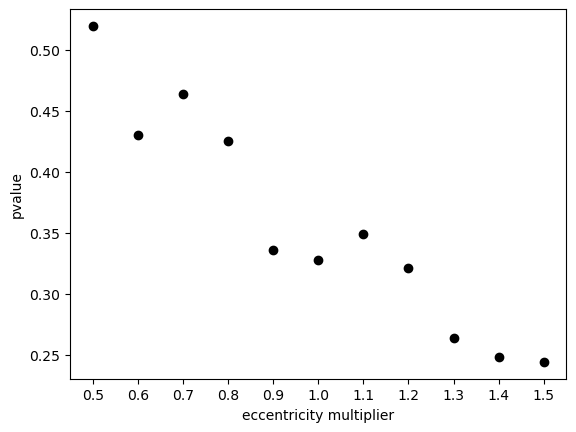

In [19]:
# find out how to include unique error bars for each stdev, saved to the array: trials_pvalue_stdev
# (indices correspond to each other)
plt.plot(kde_changing, trials_pvalue_mean, 'ko')
plt.ylabel("pvalue")
plt.xlabel('eccentricity multiplier') 
plt.xticks(kde_changing)

In [52]:
# import statistics
# statistics.stdev(ecc_pvalue[0])
# print(min(ecc_pvalue[10]))
# print(max(ecc_pvalue[10]))

0.002306872679744277
0.8052108861942998


# PDFs

Text(0.5, 0, 'period ratios')

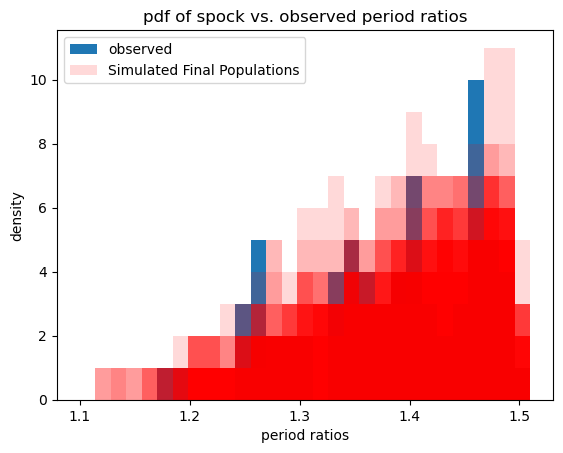

In [568]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
for q in range(num_experiments):
    spock_p_list = trials_final_pratios[q]
    if q == 0: # add label to legend
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red", label='Simulated Final Populations')
    else:
        plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.15, color="red")
plt.legend()
plt.ylabel("density")
plt.xlabel("period ratios")

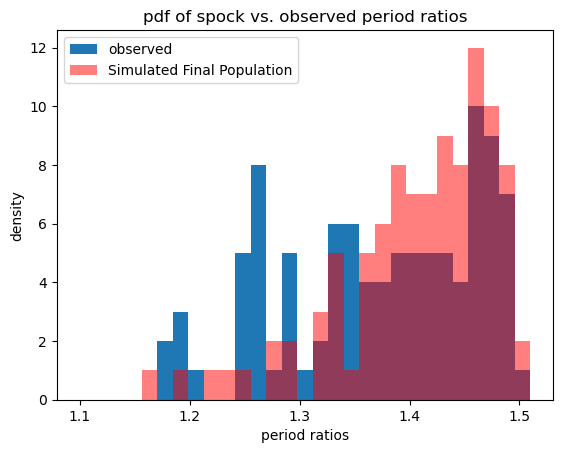

In [18]:
plt.title("pdf of spock vs. observed period ratios")
plt.hist(pratios_observed, bins=np.linspace(1.1, 1.51, bin_number), color="tab:blue", label = "observed")
plt.hist(spock_p_list, bins=np.linspace(1.1, 1.51, bin_number), alpha=.5, color="red", label='Simulated Final Population')
plt.ylabel("density")
plt.xlabel("period ratios")
plt.legend()

# CDFs

In [25]:
observed_period_cdf

array([0.01197865, 0.02414939, 0.03683564, 0.04958405, 0.06234081,
       0.07516692, 0.08801712, 0.10089234, 0.11378069, 0.12667226,
       0.1396868 , 0.15273107, 0.16589327, 0.17905747, 0.19232276,
       0.20565819, 0.21925305, 0.23285582, 0.24648112, 0.26011916,
       0.27379835, 0.28748172, 0.30122106, 0.31499029, 0.32879528,
       0.34263613, 0.35648976, 0.37037268, 0.38430246, 0.39827037,
       0.41224657, 0.42633758, 0.44043769, 0.45457873, 0.46872735,
       0.48291485, 0.4971885 , 0.51149135, 0.52580606, 0.54013423,
       0.55448802, 0.56884605, 0.58322962, 0.59762369, 0.61202044,
       0.62649956, 0.64103987, 0.65563687, 0.67031567, 0.68507613,
       0.69988783, 0.71471802, 0.72956972, 0.74443849, 0.75931563,
       0.77419855, 0.78908477, 0.80397158, 0.81886494, 0.83380079,
       0.84875639, 0.86374057, 0.87879461, 0.89386475, 0.90894711,
       0.92404369, 0.93916625, 0.95429561, 0.9694973 , 0.98470993,
       1.        ])

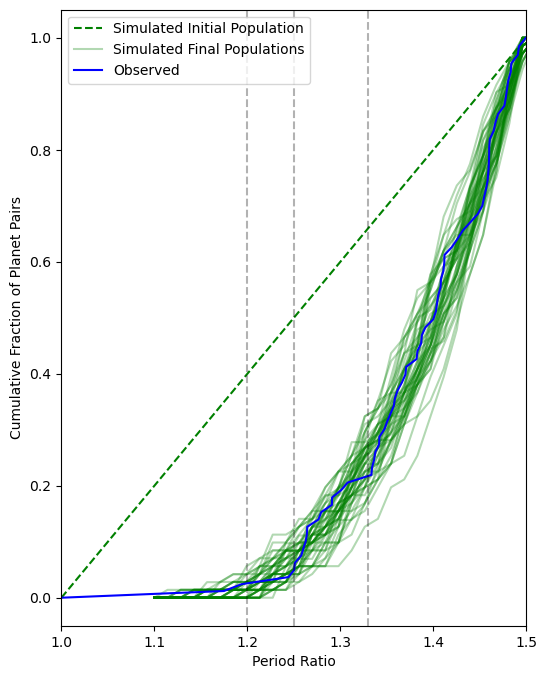

In [74]:
#Below we generate the plots for our population
#plt.style.use('./paper.mplstyle')
fig, ax = plt.subplots(figsize=(6,8))

ax.plot([1,1.5], [0,1], 'g--', label='Simulated Initial Population')
for q in range(num_experiments):
    spock_p_cumsum = trials_cumsum[q] #diff cumsum each time
    if q == 0:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3, label='Simulated Final Populations')
    else:
        ax.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green', alpha = 0.3)
        
# plot observed, don't change
ax.plot([1] + list(sorted(pratios_observed)), [0]+list(observed_period_cdf), c = 'blue', label='Observed')
ax.axvline(1.2, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.25, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.33, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.set_xlabel("Period Ratio")
ax.set_ylabel("Cumulative Fraction of Planet Pairs")
ax.set_xlim([1.,1.5])
fig.savefig('inneredge.pdf', bbox_inches='tight')

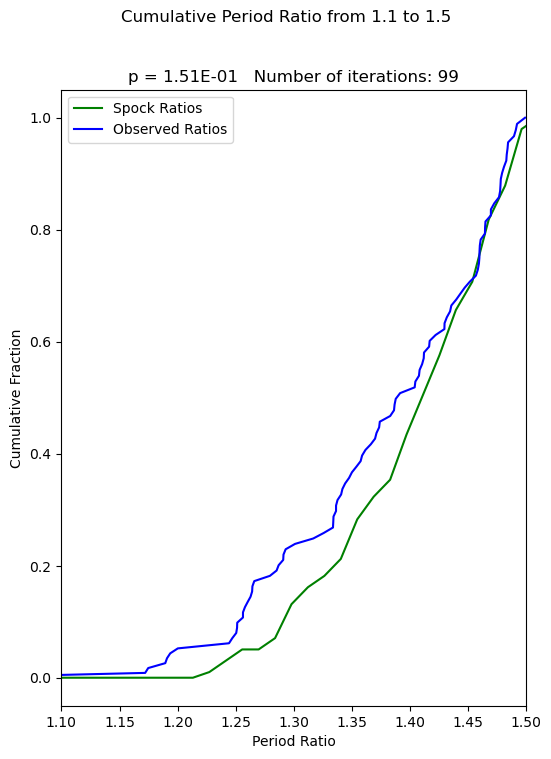

<Figure size 1000x100 with 0 Axes>

In [35]:
# literally just one experiment probs don't need?
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)

plt.plot(spock_p_base, [0]+list(spock_p_cumsum), c = 'green')
plt.plot([1] + list(pratios_observed), [0]+list(observed_period_cdf), c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(trials_pvalue[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()

# KDEs with SPOCK

same problem as above graph with one green line. if these are actually used, we need to fix these. They currently are only using the very last experiment, only one experiment, 71 inner pratios

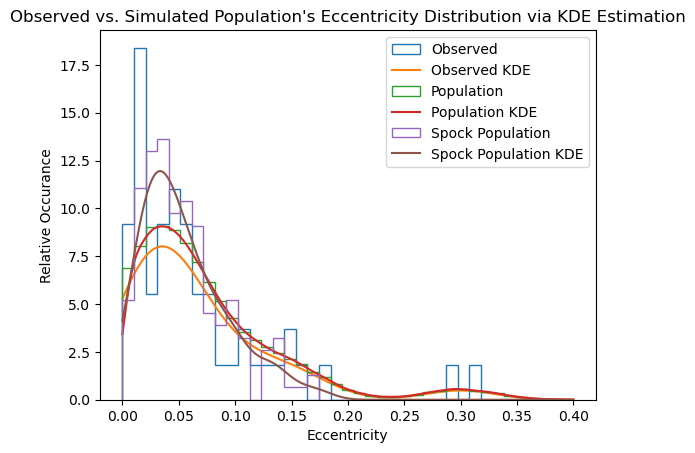

In [35]:
# Create a histogram of the original data
n, bins_e, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid_e, kde_e(x_grid_e), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(e_list, bins=bins_e, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples, e_list spock selected from
kde_new_e = gaussian_kde(e_list)
plt.plot(x_grid_e, kde_new_e(x_grid_e), label='Population KDE')

#plot the actual eccentricities spock took
n_s_new, bins_s_new, patches_s_new = plt.hist(spock_e_list, bins=bins_e, histtype='step', density=True, label = 'Spock Population')
kde_s_new = gaussian_kde(spock_e_list)
plt.plot(x_grid_e, kde_s_new(x_grid_e), label='Spock Population KDE')


# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Eccentricity Distribution via KDE Estimation")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()

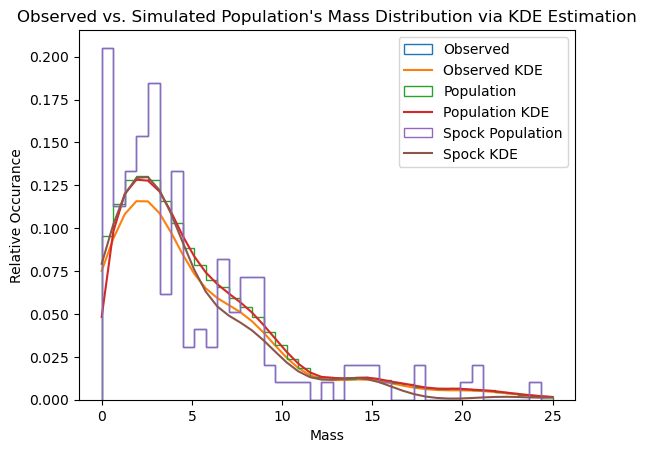

In [188]:
#masses after spock
# Create a histogram of the original data
n, bins, patches = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples, m_list spock selected from
n_new, bins_new, patches_new = plt.hist(m_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(m_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')

#plot spock mass distribution
ns, binss, patchess = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Spock Population')
kdes=gaussian_kde(spock_m_list)
plt.plot(x_grid, kdes(x_grid), label='Spock KDE')

# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Mass Distribution via KDE Estimation")
plt.xlabel("Mass")
plt.ylabel("Relative Occurance")
plt.legend()


# Show the plot
plt.show()